# CCE Moorings - Temporal Scales Analysis for Along and Cross-shelf Velocity

**Purpose**: Code for computing the mean autocorrelation function for scalar fields from CCE moorings.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Import python libraries

In [ ]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr_optimize, compute_decor_scale_optimize
from spectra import spectrum1D_frequency, spectral_slope
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function

Set data analysis parameters

In [3]:
# Set processing parameters
option_mooring       = 'CCE1' # Specifies which mooring will analyzed. 
option_obs           = 'ADCP' # Specifies the observational instrumentation to process. Options include: 'CTD', 'CHL', 'ADCP'
option_grid          = 0      # Specifies whether the gridded product or the nearest neighbor depth-correct approach approach is used
option_plot          = 0 

# Set time and space parameters
T               = 1*(60)*(60)                         # Spcifies the time interval for model run. Units: seconds
estimator       = 'biased'                            # Specifies the approach for estimating the autocorrelation function  
start_time      = datetime(2015, 1, 1, 0, 0, 0)       # Specifies the start time of the event period  datetime(2016, 1, 1, 0, 0, 0) datetime(2025, 3, 12, 0, 0, 0)
end_time        = datetime(2015, 12, 31, 23, 59, 59)  # Specifies the end time of the event period        datetime(2025, 12, 31, 23, 59, 59)  datetime(2025, 6, 23, 0, 0, 0) 
event_time_bnds = [start_time, end_time]              # Specifies the event period

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Load CCE processed data

In [4]:
# Set the file name and read in the data file
if option_grid == 1:
    filename_CCE = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_gridded_data.nc"
else:
    filename_CCE = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_data.nc"
nc_CCE = Dataset(filename_CCE, 'r')

# Extract data variables
depth           = nc_CCE.variables['depth'][:]
time            = num2date(nc_CCE.variables['time'][:], nc_CCE.variables['time'].units)
time_daily      = num2date(nc_CCE.variables['time_daily'][:], nc_CCE.variables['time_daily'].units)
lon             = nc_CCE.variables['LON'][:]
lat             = nc_CCE.variables['LAT'][:]

U               = nc_CCE.variables['U'][:]
V               = nc_CCE.variables['V'][:]
U_depth         = nc_CCE.variables['U_depth'][:]
V_depth         = nc_CCE.variables['V_depth'][:]
U_daily         = nc_CCE.variables['U_daily'][:]
V_daily         = nc_CCE.variables['V_daily'][:]

U_shelf               = nc_CCE.variables['U_shelf'][:]
V_shelf               = nc_CCE.variables['V_shelf'][:]
U_shelf_depth         = nc_CCE.variables['U_shelf_depth'][:]
V_shelf_depth         = nc_CCE.variables['V_shelf_depth'][:]
U_shelf_daily         = nc_CCE.variables['U_shelf_daily'][:]
V_shelf_daily         = nc_CCE.variables['V_shelf_daily'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])
time_daily_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_daily])

Preform scale analysis looping through bin averaging window lengths

In [36]:
# Set parameters
nwindow,ntime = 24,len(U_shelf_depth)
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/sec

#Convert to seconds since start time
t0 = time[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time])

# Initialize arrays 
autocorr_u       = np.zeros((ntime,nwindow))
time_scale_u     = np.zeros((ntime,nwindow))
L_t_u            = np.zeros((nwindow))
struct_u         = np.zeros((ntime,nwindow))

# Set counter
cn_bin = 0 

# Initialize the ith time series 
data_ts = U_shelf_depth

# Loop through Bin window lengths 
for ibin in range(0,nwindow):

    # Set bin hour counter
    bin_hours = ibin + 1  # Bin size in hours (1 to 24)
    
    # Set progress bar
    sys.stdout.write(f"\rProgress: {bin_hours}/24 hour bins")
    sys.stdout.flush()

    # Time binning
    bin_seconds = bin_hours * 3600
    time_elapsed_hours = np.array([(t - t0).total_seconds() for t in time])
    bin_index = np.floor(time_elapsed_hours / bin_seconds).astype(int)
    unique_bins = np.unique(bin_index)

    # Bin-average the data
    binned_data = np.array([np.mean(data_ts[bin_index == b]) for b in unique_bins])
    binned_times = np.array([np.mean(time_elapsed_hours[bin_index == b]) for b in unique_bins])

    # Create masked array
    binned_data_m = np.ma.masked_array(binned_data, mask=False)

    # Remove annual and semi-annual cycle 
    hfit, _, _, _ = unweighted_lsf(binned_data_m, binned_times, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
    data_ts_rm = binned_data_m - hfit

    # Detrend data record 
    data_dt = detrend(data_ts_rm, binned_times, mean = 0)

    # Compute autocorrelation function
    autocorr_tmp, _, _, _, time_scale_tmp, _ = compute_autocorr_optimize(data_dt, binned_times, len(data_dt), estimator, 0)
    autocorr_u[:len(data_dt), ibin] = autocorr_tmp
    time_scale_u[:len(data_dt), ibin] = time_scale_tmp

    # Compute the decorrelation scale
    L_t_u[ibin] = compute_decor_scale_optimize(autocorr_tmp,time_scale_tmp,bin_seconds,'unbiased',0)

    # Compute structure function
    struct_tmp, _ = compute_structure_function(data_ts, len(binned_data), orders=[1, 2, 3, 4])
    struct_u[:len(binned_data), ibin] = struct_tmp[2]

# Convert time scale to units of days
Lt_u = L_t_u*(1/60)*(1/60)*(1/24)

Progress: 1/24 hour bins

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_26719/3891508473.py:38: UserWarning: Warning: converting a masked element to nan.
  binned_data = np.array([np.mean(data_ts[bin_index == b]) for b in unique_bins])
/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/autocorr.py:85: RuntimeWarning: Mean of empty slice
  data_mean     = np.nanmean(data_filled)
/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/autocorr.py:100: RuntimeWarning: invalid value encountered in scalar divide
  Rnorm = np.nansum(data_demeaned * data_demeaned) / count_valid
/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  r

Progress: 24/24 hour bins

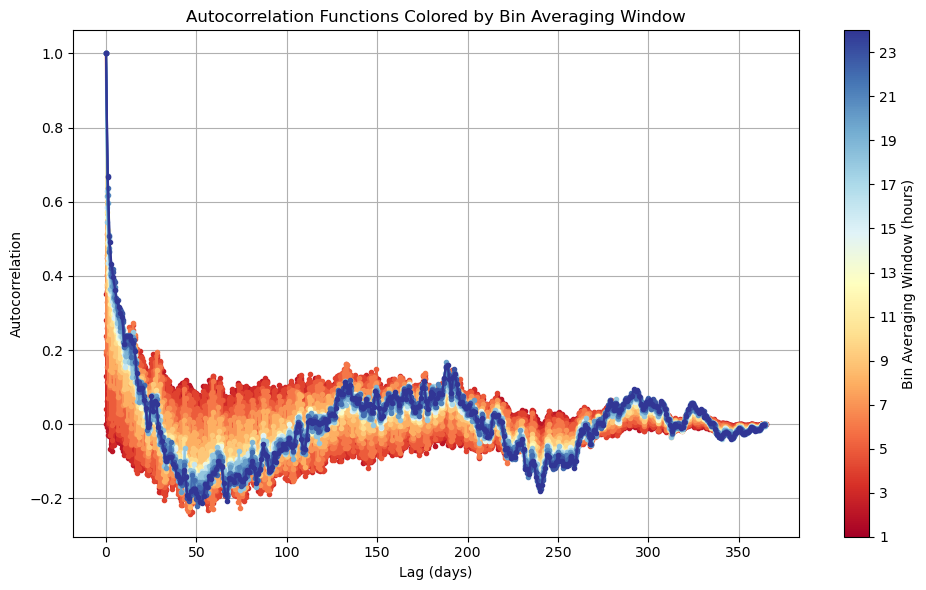

In [41]:
# Number of bin windows
n_bins = autocorr_u.shape[1]  # Should be 24 (1 to 24 hr)

# Time lags for autocorrelation (convert to hours or days as appropriate)
# Assume each lag step corresponds to one binned data point
# If you want actual time, use time_scale_u[:, ibin] if available
lags = np.arange(autocorr_u.shape[0])  # Adjust this if your lag has time units

# Convert to days
time_scale_u_days = time_scale_u / (60 * 60 * 24)


# Set up colormap: one color for each bin window
cmap = cm.RdYlBu
norm = mcolors.Normalize(vmin=1, vmax=n_bins)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

for ibin in range(n_bins):
    color = cmap(norm(ibin + 1))  # Color for current bin
    acf = autocorr_u[:, ibin]
    lag_days = time_scale_u_days[:, ibin]

    # Mask invalid or non-positive values
    mask = (~np.isclose(acf, 0)) & np.isfinite(acf) #& (lag_days > 0)
    
    ax.plot(lag_days[mask], acf[mask], '.-', color=color)

# Aesthetics
ax.set_xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Functions Colored by Bin Averaging Window")
plt.grid(True)
#plt.xlim([0, 10])

# Colorbar
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(1, n_bins+1, 2))
cbar.set_label("Bin Averaging Window (hours)")

plt.tight_layout()
plt.show()


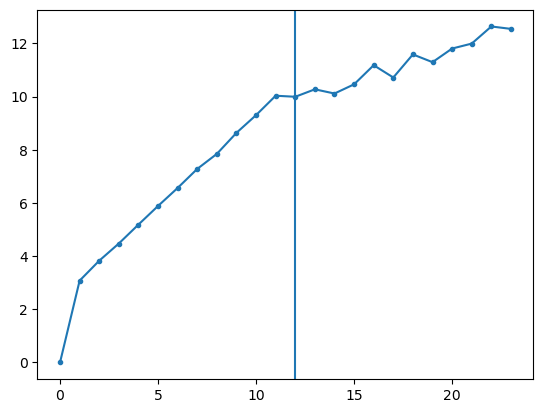

In [40]:
plt.plot(Lt_u,'.-')
plt.axvline(12)
plt.show()

In [31]:
bin_seconds

259200

In [32]:
time_scale_tmp

array([       0.,   259200.,   518400.,   777600.,  1036800.,  1296000.,
        1555200.,  1814400.,  2073600.,  2332800.,  2592000.,  2851200.,
        3110400.,  3369600.,  3628800.,  3888000.,  4147200.,  4406400.,
        4665600.,  4924800.,  5184000.,  5443200.,  5702400.,  5961600.,
        6220800.,  6480000.,  6739200.,  6998400.,  7257600.,  7516800.,
        7776000.,  8035200.,  8294400.,  8553600.,  8812800.,  9072000.,
        9331200.,  9590400.,  9849600., 10108800., 10368000., 10627200.,
       10886400., 11145600., 11404800., 11664000., 11923200., 12182400.,
       12441600., 12700800., 12960000., 13219200., 13478400., 13737600.,
       13996800., 14256000., 14515200., 14774400., 15033600., 15292800.,
       15552000., 15811200., 16070400., 16329600., 16588800., 16848000.,
       17107200., 17366400., 17625600., 17884800., 18144000., 18403200.,
       18662400., 18921600., 19180800., 19440000., 19699200., 19958400.,
       20217600., 20476800., 20736000., 20995200., 